,Point,Cluster,Role
0,A,C0,core
1,B,C0,core
2,C,C0,core
3,D,C0,core
4,E,Noise,noise


Saved plot to: /content/dbscan_result.png


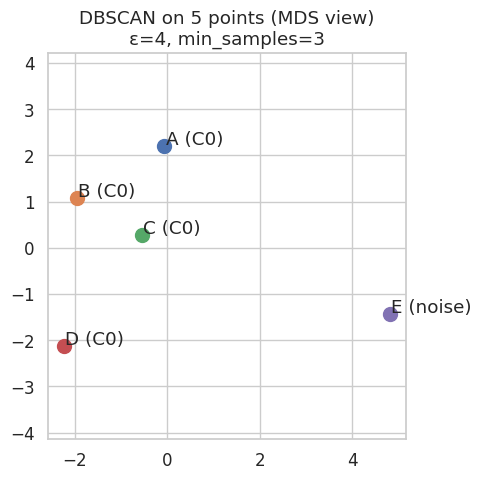

In [3]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from pathlib import Path



# Input (from q1)
labels = np.array(["A","B","C","D","E"])
D = np.array([
    [0,2,2,5,6],
    [2,0,2,3,7],
    [2,2,0,3,6],
    [5,3,3,0,7],
    [6,7,6,7,0]
], dtype=float)

eps = 4
min_samples = 3

# DBSCAN w/  precomputed distances
db = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed")
db.fit(D)
cluster_ids = db.labels_  # -1 means noise

# Determine core points
core_mask = np.zeros_like(cluster_ids, dtype=bool)
core_mask[db.core_sample_indices_] = True

# Summary table
status = []
for i, lab in enumerate(labels):
    role = "noise" if cluster_ids[i] == -1 else ("core" if core_mask[i] else "border")
    status.append({"Point": lab,
                   "Cluster": "Noise" if cluster_ids[i] == -1 else f"C{cluster_ids[i]}",
                   "Role": role})
df = pd.DataFrame(status)
display(df)

# 2D visualization (MDS embedding)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
coords = mds.fit_transform(D)

plt.figure(figsize=(5,5))
for i, (x,y) in enumerate(coords):
    plt.scatter(x, y, s=100)  # removed  edgecolors -->  avoid warning
    plt.text(x+0.03, y+0.03, f"{labels[i]} ({'noise' if cluster_ids[i]==-1 else 'C'+str(cluster_ids[i])})")

plt.title("DBSCAN on 5 points (MDS view)\nε=4, min_samples=3")
plt.axis('equal')
plt.tight_layout()

# Save
out_path = Path("dbscan_result.png")

plt.savefig(out_path, dpi=200, bbox_inches='tight')
print(f"Saved plot to: {out_path.resolve()}")

plt.show()


Saving secondary__mushroom_dataset-1.csv to secondary__mushroom_dataset-1 (1).csv
User uploaded file "secondary__mushroom_dataset-1 (1).csv" with length 2896328 bytes
Index(['class', 'cap-diameter', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-height', 'stem-width', 'stem-root', 'stem-surface', 'stem-color',
       'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color',
       'habitat', 'season'],
      dtype='object')
(61069, 21)


,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w


Random Forest (Bagging): {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'F1-score': 1.0, 'ROC-AUC': 1.0}
XGBoost (Boosting): {'Accuracy': 0.9999181267398067, 'Precision': 0.9998538225405642, 'Recall': 1.0, 'F1-score': 0.9999269059279292, 'ROC-AUC': 0.9999999183854686}
Stacking: {'Accuracy': 0.9998362534796136, 'Precision': 0.9997076878105817, 'Recall': 1.0, 'F1-score': 0.9998538225405642, 'ROC-AUC': 0.9999998639757812}


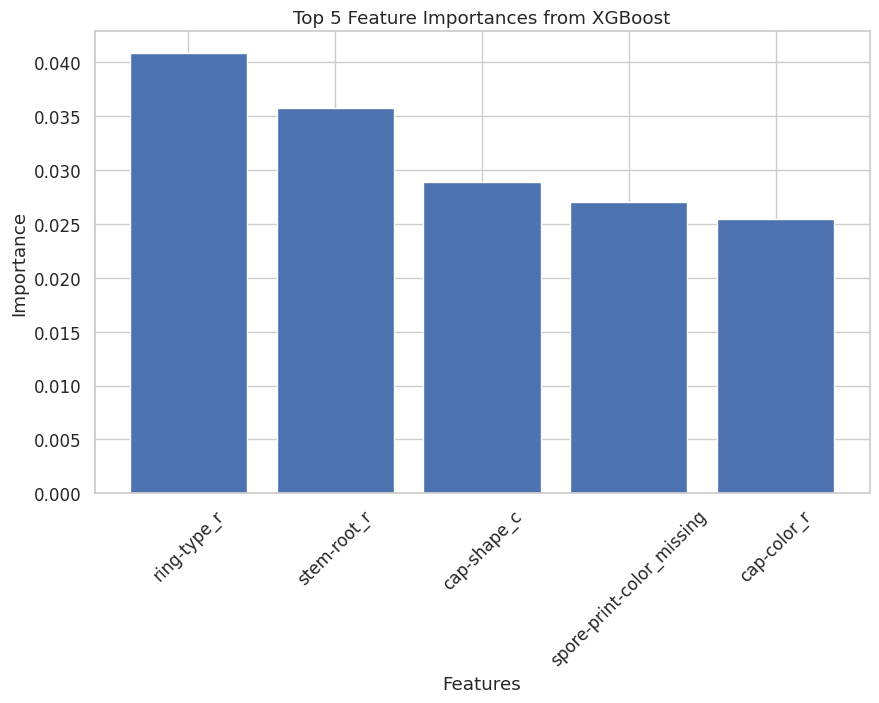

In [4]:
!pip install xgboost
!pip install "numpy<2.0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid", font_scale=1.1)

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  file_name = fn

df = pd.read_csv(file_name, sep=';', na_values='')

print(df.columns)
print(df.shape)
display(df.head())

# Preprocessing
# Identify numeric and categorical columns
numeric_cols = ['cap-diameter', 'stem-height', 'stem-width']
categorical_cols = [col for col in df.columns if col not in numeric_cols + ['class']]

# Fill missing values
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].mean())

for col in categorical_cols:
    df[col] = df[col].fillna('missing')

# Encode categorical variables
df = pd.get_dummies(df, columns=categorical_cols)

# Encode target
df['class'] = df['class'].map({'e': 0, 'p': 1})

# Split data
X = df.drop('class', axis=1)
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to report metrics
def report_metrics(y_true, y_pred, y_proba):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba)
    }

# Bagging: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]
metrics_rf = report_metrics(y_test, y_pred_rf, y_proba_rf)

# Boosting: XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
metrics_xgb = report_metrics(y_test, y_pred_xgb, y_proba_xgb)

# Stacking
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]
meta_learner = LogisticRegression()
stacking = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_test)
y_proba_stack = stacking.predict_proba(X_test)[:, 1]
metrics_stack = report_metrics(y_test, y_pred_stack, y_proba_stack)

# Print metrics
print("Random Forest (Bagging):", metrics_rf)
print("XGBoost (Boosting):", metrics_xgb)
print("Stacking:", metrics_stack)

# Feature Importance with XGBoost
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1][:5]
top_features = X.columns[indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(indices)), importances[indices])
plt.xticks(range(len(indices)), top_features, rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 5 Feature Importances from XGBoost')
plt.show()